# LSTM-Autoencoder for SCADA Anomaly Detection
## Capturing Temporal Patterns in Time-Series Sensor Data

This notebook implements an **LSTM-Autoencoder** hybrid model that combines:
- **LSTM (Long Short-Term Memory)**: Captures temporal dependencies and sequential patterns
- **Autoencoder**: Learns compressed representations and detects anomalies via reconstruction error

### Why LSTM-Autoencoder for SCADA?

| Aspect | Standard Autoencoder | LSTM-Autoencoder |
|--------|---------------------|------------------|
| Input | Single time point | Sequence of time points |
| Temporal patterns |  Cannot capture |  Captures dependencies |
| Attack detection | Point anomalies only | Point + sequential anomalies |
| Stealthy attacks | May miss gradual changes | Detects pattern deviations |

### Architecture Overview
```
Input Sequence [batch, timesteps, features]
        ↓
    LSTM Encoder (learns temporal patterns)
        ↓
    Latent Space (compressed representation)
        ↓
    LSTM Decoder (reconstructs sequence)
        ↓
Output Sequence [batch, timesteps, features]
        ↓
    Reconstruction Error → Anomaly Score
```

---

## Step 1: Setup and Imports

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# print("Google Drive mounted!")
print("Google Drive mounting disabled for local runtime.")

Google Drive mounting disabled for local runtime.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import warnings
import joblib
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, LSTM, Dense, RepeatVector, TimeDistributed,
    Dropout, BatchNormalization, Bidirectional
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Check GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print("\nAll imports successful!")

TensorFlow version: 2.20.0
GPU available: []

All imports successful!


## Step 2: Configuration

In [3]:
# =============================================================
# CONFIGURATION
# =============================================================

# Data paths - UPDATE THESE TO YOUR LOCAL FILE PATHS!
NORMAL_DATA_PATH = '/Volumes/@tigasprilm@bx.d/u.du.d/0.d/Software Projects/VSCode/TKPSupport/SWaT_Normal.csv'
ATTACK_DATA_PATH = '/Volumes/@tigasprilm@bx.d/u.du.d/0.d/Software Projects/VSCode/TKPSupport/SWaT_Attack.csv'
MODEL_SAVE_PATH = '/Volumes/@tigasprilm@bx.d/u.du.d/0.d/Software Projects/VSCode/TKPSupport/models/'

# Sequence parameters
SEQUENCE_LENGTH = 30      # Number of timesteps in each sequence
STEP_SIZE = 1             # Step size for sliding window

# Model architecture
LATENT_DIM = 32           # Dimension of latent space
LSTM_UNITS_1 = 64         # First LSTM layer units
LSTM_UNITS_2 = 32         # Second LSTM layer units
DROPOUT_RATE = 0.2        # Dropout rate

# Training parameters
EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.1
EARLY_STOP_PATIENCE = 10

# Detection parameters
THRESHOLD_PERCENTILE = 95  # Percentile for anomaly threshold

# Random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Configuration:")
print(f"  Sequence length: {SEQUENCE_LENGTH}")
print(f"  Latent dimension: {LATENT_DIM}")
print(f"  LSTM units: {LSTM_UNITS_1} → {LSTM_UNITS_2}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")

Configuration:
  Sequence length: 30
  Latent dimension: 32
  LSTM units: 64 → 32
  Batch size: 256
  Epochs: 100


## Step 3: Load and Preprocess Data

In [4]:
def load_swat_data(file_path, header_row=1):
    """Load SWaT dataset."""
    print(f"Loading: {file_path}")
    df = pd.read_csv(file_path, header=header_row)
    df.columns = df.columns.str.strip()
    print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    return df

# Load data
normal_df = load_swat_data(NORMAL_DATA_PATH)
attack_df = load_swat_data(ATTACK_DATA_PATH)

print(f"\n Normal samples: {len(normal_df):,}")
print(f" Attack samples: {len(attack_df):,}")

Loading: /Volumes/@tigasprilm@bx.d/u.du.d/0.d/Software Projects/VSCode/TKPSupport/SWaT_Normal.csv
  Shape: 495,000 rows × 53 columns
Loading: /Volumes/@tigasprilm@bx.d/u.du.d/0.d/Software Projects/VSCode/TKPSupport/SWaT_Attack.csv
  Shape: 449,919 rows × 53 columns

 Normal samples: 495,000
 Attack samples: 449,919


In [5]:
# Identify sensor columns
exclude_cols = ['Timestamp', 'timestamp', 'Normal/Attack', 'label', 'Label']
sensor_cols = [col for col in attack_df.columns if col not in exclude_cols]
sensor_cols = attack_df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Found {len(sensor_cols)} sensor columns")

# Get label column
label_col = None
for col in ['Normal/Attack', 'label', 'Label']:
    if col in attack_df.columns:
        label_col = col
        break

print(f"Label column: {label_col}")

# Create binary labels for attack data
attack_df['label_binary'] = (attack_df[label_col] == 'Attack').astype(int)
print(f"\nAttack distribution:")
print(attack_df['label_binary'].value_counts())

Found 51 sensor columns
Label column: Normal/Attack

Attack distribution:
label_binary
0    395335
1     54584
Name: count, dtype: int64


In [6]:
# Extract features
X_normal = normal_df[sensor_cols].values
X_attack = attack_df[sensor_cols].values
y_attack = attack_df['label_binary'].values

# Handle NaN values
X_normal = pd.DataFrame(X_normal).fillna(method='ffill').fillna(method='bfill').values
X_attack = pd.DataFrame(X_attack).fillna(method='ffill').fillna(method='bfill').values

print(f"Normal data shape: {X_normal.shape}")
print(f"Attack data shape: {X_attack.shape}")

n_features = X_normal.shape[1]
print(f"Number of features: {n_features}")

Normal data shape: (495000, 51)
Attack data shape: (449919, 51)
Number of features: 51


In [7]:
# Scale data using MinMaxScaler (better for LSTM)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_normal)  # Fit only on normal data

X_normal_scaled = scaler.transform(X_normal)
X_attack_scaled = scaler.transform(X_attack)

print("Data scaled to [0, 1] range")
print(f"  Normal min: {X_normal_scaled.min():.4f}, max: {X_normal_scaled.max():.4f}")
print(f"  Attack min: {X_attack_scaled.min():.4f}, max: {X_attack_scaled.max():.4f}")

Data scaled to [0, 1] range
  Normal min: 0.0000, max: 1.0000
  Attack min: -4.0092, max: 2.1974


## Step 4: Create Sequences

In [8]:
def create_sequences(data, labels=None, seq_length=30, step=1):
    """
    Create sequences for LSTM input using sliding window.

    Args:
        data: Input data (n_samples, n_features)
        labels: Optional labels for each sample
        seq_length: Length of each sequence
        step: Step size for sliding window

    Returns:
        sequences: (n_sequences, seq_length, n_features)
        seq_labels: Labels for each sequence (if labels provided)
    """
    sequences = []
    seq_labels = []

    for i in range(0, len(data) - seq_length + 1, step):
        seq = data[i:i + seq_length]
        sequences.append(seq)

        if labels is not None:
            # Label sequence as attack if ANY point in sequence is attack
            seq_label = 1 if labels[i:i + seq_length].max() > 0 else 0
            seq_labels.append(seq_label)

    sequences = np.array(sequences)

    if labels is not None:
        return sequences, np.array(seq_labels)
    return sequences

print(f"Creating sequences with length={SEQUENCE_LENGTH}, step={STEP_SIZE}...")

Creating sequences with length=30, step=1...


In [9]:
# Create sequences from normal data (for training)
print("\nCreating normal sequences...")
X_normal_seq = create_sequences(X_normal_scaled.astype(np.float32), seq_length=SEQUENCE_LENGTH, step=STEP_SIZE)
print(f"  Normal sequences shape: {X_normal_seq.shape}")

# Create sequences from attack data (for testing)
print("\nCreating attack sequences...")
X_attack_seq, y_attack_seq = create_sequences(
    X_attack_scaled.astype(np.float32),
    labels=y_attack,
    seq_length=SEQUENCE_LENGTH,
    step=STEP_SIZE
)
print(f"  Attack sequences shape: {X_attack_seq.shape}")
print(f"  Attack labels shape: {y_attack_seq.shape}")
print(f"  Attack sequence ratio: {y_attack_seq.mean()*100:.2f}%")


Creating normal sequences...
  Normal sequences shape: (494971, 30, 51)

Creating attack sequences...
  Attack sequences shape: (449890, 30, 51)
  Attack labels shape: (449890,)
  Attack sequence ratio: 12.36%


In [10]:
# Split normal data for training and validation
X_train, X_val = train_test_split(
    X_normal_seq,
    test_size=VALIDATION_SPLIT,
    random_state=RANDOM_STATE
)

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Test sequences (attack data): {X_attack_seq.shape}")

Training sequences: (445473, 30, 51)
Validation sequences: (49498, 30, 51)
Test sequences (attack data): (449890, 30, 51)


---
## Step 5: Build LSTM-Autoencoder Model

In [11]:
def build_lstm_autoencoder(seq_length, n_features, latent_dim=32,
                           lstm_units_1=64, lstm_units_2=32, dropout=0.2):
    """
    Build LSTM-Autoencoder model.

    Architecture:
        Encoder: LSTM → LSTM → Dense (latent)
        Decoder: RepeatVector → LSTM → LSTM → TimeDistributed(Dense)
    """

    # Input
    inputs = Input(shape=(seq_length, n_features), name='input')

    # ==================== ENCODER ====================
    # First LSTM layer - returns sequences
    x = LSTM(lstm_units_1, activation='tanh', return_sequences=True,
             name='encoder_lstm_1')(inputs)
    x = Dropout(dropout)(x)

    # Second LSTM layer - returns only last output
    x = LSTM(lstm_units_2, activation='tanh', return_sequences=False,
             name='encoder_lstm_2')(x)
    x = Dropout(dropout)(x)

    # Latent space
    latent = Dense(latent_dim, activation='relu', name='latent_space')(x)

    # ==================== DECODER ====================
    # Repeat latent vector for each timestep
    x = RepeatVector(seq_length, name='repeat_vector')(latent)

    # First decoder LSTM
    x = LSTM(lstm_units_2, activation='tanh', return_sequences=True,
             name='decoder_lstm_1')(x)
    x = Dropout(dropout)(x)

    # Second decoder LSTM
    x = LSTM(lstm_units_1, activation='tanh', return_sequences=True,
             name='decoder_lstm_2')(x)
    x = Dropout(dropout)(x)

    # Output layer - reconstruct original features for each timestep
    outputs = TimeDistributed(Dense(n_features, activation='sigmoid'),
                              name='output')(x)

    # Build model
    model = Model(inputs=inputs, outputs=outputs, name='LSTM_Autoencoder')

    return model

print("LSTM-Autoencoder architecture defined")

LSTM-Autoencoder architecture defined


In [12]:
# Build model
model = build_lstm_autoencoder(
    seq_length=SEQUENCE_LENGTH,
    n_features=n_features,
    latent_dim=LATENT_DIM,
    lstm_units_1=LSTM_UNITS_1,
    lstm_units_2=LSTM_UNITS_2,
    dropout=DROPOUT_RATE
)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='mse',
    metrics=['mae']
)

# Print summary
model.summary()

Model: "LSTM_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 30, 51)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm_1 (LSTM)           │ (None, 30, 64)         │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm_2 (LSTM)           │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm_1 (LSTM)           │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm_2 (LSTM)           │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (TimeDistributed)        │ (None, 30, 51)         │         3,315 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,635 (311.07 KB)

 Trainable params: 79,635 (311.07 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Visualize architecture
try:
    tf.keras.utils.plot_model(
        model,
        to_file='lstm_autoencoder_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        dpi=100
    )
    print("Model architecture saved to: lstm_autoencoder_architecture.png")
except:
    print("Could not save model visualization (graphviz may not be installed)")

You must install pydot (`pip install pydot`) for `plot_model` to work.
Model architecture saved to: lstm_autoencoder_architecture.png


---
## Step 6: Train Model

In [14]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOP_PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print("Callbacks configured:")
print(f"  - EarlyStopping (patience={EARLY_STOP_PATIENCE})")
print(f"  - ReduceLROnPlateau")

Callbacks configured:
  - EarlyStopping (patience=10)
  - ReduceLROnPlateau


In [15]:
# Train model
print("="*60)
print("TRAINING LSTM-AUTOENCODER")
print("="*60)
print(f"Training on {len(X_train):,} normal sequences")
print(f"Validating on {len(X_val):,} normal sequences")
print("-"*60)

start_time = time.time()

history = model.fit(
    X_train, X_train,  # Autoencoder: input = target
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print("-"*60)
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

TRAINING LSTM-AUTOENCODER
Training on 445,473 normal sequences
Validating on 49,498 normal sequences
------------------------------------------------------------
Epoch 1/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 195s 110ms/step - loss: 0.0374 - mae: 0.1063 - val_loss: 0.0093 - val_mae: 0.0373 - learning_rate: 0.0010
Epoch 2/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 330s 190ms/step - loss: 0.0100 - mae: 0.0403 - val_loss: 0.0085 - val_mae: 0.0343 - learning_rate: 0.0010
Epoch 3/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 510s 293ms/step - loss: 0.0080 - mae: 0.0350 - val_loss: 0.0047 - val_mae: 0.0243 - learning_rate: 0.0010
Epoch 4/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 178s 102ms/step - loss: 0.0053 - mae: 0.0274 - val_loss: 0.0035 - val_mae: 0.0205 - learning_rate: 0.0010
Epoch 5/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 175s 100ms/step - loss: 0.0041 - mae: 0.0237 - val_loss: 0.0028 - val_mae: 0.0178 - learning_rate: 0.0010
Epoch 6/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 190s 109ms/step - loss: 0.0033 - mae: 0.0213 - val

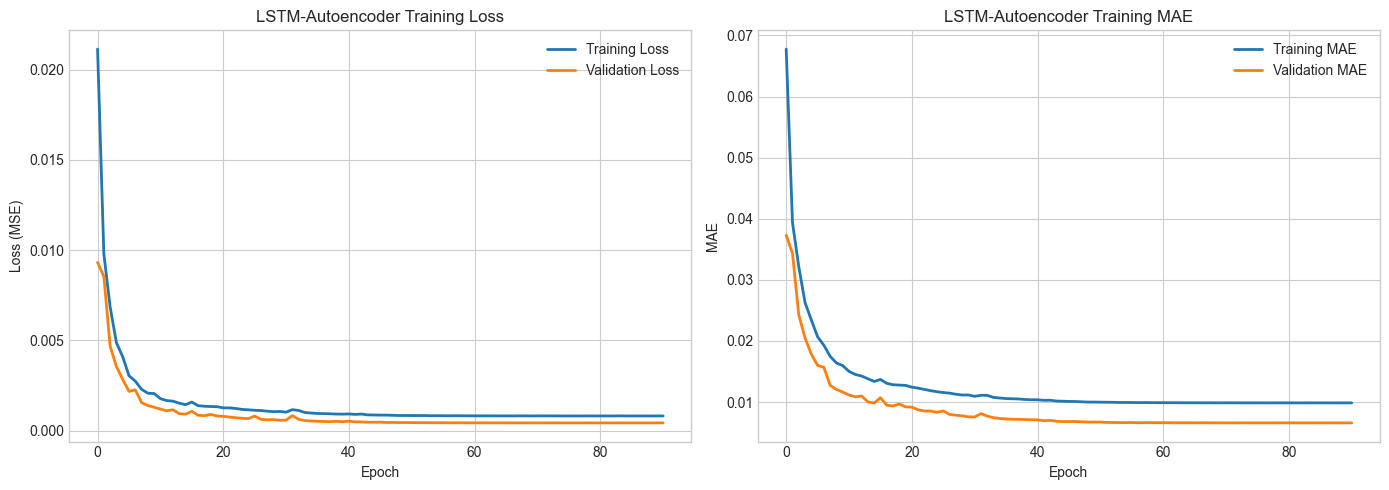

Saved: lstm_ae_training_history.png


In [16]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('LSTM-Autoencoder Training Loss')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('LSTM-Autoencoder Training MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('lstm_ae_training_history.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: lstm_ae_training_history.png")

---
## Step 7: Calculate Reconstruction Errors

In [17]:
def calculate_reconstruction_error(model, sequences, method='mse'):
    """
    Calculate reconstruction error for each sequence.

    Args:
        model: Trained autoencoder
        sequences: Input sequences
        method: 'mse' or 'mae'

    Returns:
        errors: Reconstruction error for each sequence
    """
    # Get reconstructions
    reconstructions = model.predict(sequences, verbose=0)

    if method == 'mse':
        # Mean Squared Error per sequence
        errors = np.mean(np.square(sequences - reconstructions), axis=(1, 2))
    else:
        # Mean Absolute Error per sequence
        errors = np.mean(np.abs(sequences - reconstructions), axis=(1, 2))

    return errors, reconstructions

In [18]:
# Calculate reconstruction errors
print("Calculating reconstruction errors...")

# Normal data (training) - for threshold calculation
print("  Processing training data...")
train_errors, _ = calculate_reconstruction_error(model, X_train)

# Validation data
print("  Processing validation data...")
val_errors, _ = calculate_reconstruction_error(model, X_val)

# Attack/test data
print("  Processing test data...")
test_errors, test_reconstructions = calculate_reconstruction_error(model, X_attack_seq)

print(f"\n Errors calculated")
print(f"  Training errors - mean: {train_errors.mean():.6f}, std: {train_errors.std():.6f}")
print(f"  Validation errors - mean: {val_errors.mean():.6f}, std: {val_errors.std():.6f}")
print(f"  Test errors - mean: {test_errors.mean():.6f}, std: {test_errors.std():.6f}")

Calculating reconstruction errors...
  Processing training data...
  Processing validation data...
  Processing test data...

 Errors calculated
  Training errors - mean: 0.000417, std: 0.001169
  Validation errors - mean: 0.000431, std: 0.001240
  Test errors - mean: 0.182855, std: 0.149066


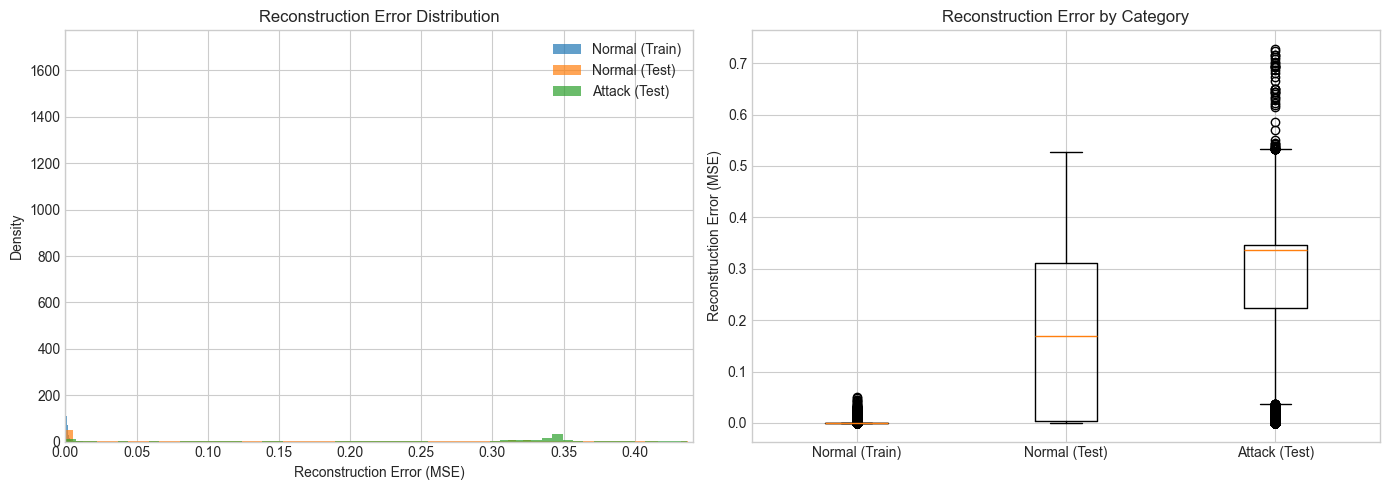

Saved: lstm_ae_error_distribution.png


In [19]:
# Plot error distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train_errors, bins=100, alpha=0.7, label='Normal (Train)', density=True)
axes[0].hist(test_errors[y_attack_seq == 0], bins=100, alpha=0.7, label='Normal (Test)', density=True)
axes[0].hist(test_errors[y_attack_seq == 1], bins=100, alpha=0.7, label='Attack (Test)', density=True)
axes[0].set_xlabel('Reconstruction Error (MSE)')
axes[0].set_ylabel('Density')
axes[0].set_title('Reconstruction Error Distribution')
axes[0].legend()
axes[0].set_xlim(0, np.percentile(test_errors, 99))

# Box plot
error_data = [
    train_errors,
    test_errors[y_attack_seq == 0],
    test_errors[y_attack_seq == 1]
]
axes[1].boxplot(error_data, labels=['Normal (Train)', 'Normal (Test)', 'Attack (Test)'])
axes[1].set_ylabel('Reconstruction Error (MSE)')
axes[1].set_title('Reconstruction Error by Category')

plt.tight_layout()
plt.savefig('lstm_ae_error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: lstm_ae_error_distribution.png")

---
## Step 8: Determine Anomaly Threshold

In [20]:
# Calculate threshold from training data
threshold = np.percentile(train_errors, THRESHOLD_PERCENTILE)

print(f"Anomaly Detection Threshold:")
print(f"  Percentile: {THRESHOLD_PERCENTILE}%")
print(f"  Threshold value: {threshold:.6f}")
print(f"\nTraining error statistics:")
print(f"  Min: {train_errors.min():.6f}")
print(f"  Max: {train_errors.max():.6f}")
print(f"  Mean: {train_errors.mean():.6f}")
print(f"  Median: {np.median(train_errors):.6f}")
print(f"  Std: {train_errors.std():.6f}")

Anomaly Detection Threshold:
  Percentile: 95%
  Threshold value: 0.001781

Training error statistics:
  Min: 0.000023
  Max: 0.050214
  Mean: 0.000417
  Median: 0.000128
  Std: 0.001169


In [21]:
# Test different thresholds
percentiles = [90, 92, 94, 95, 96, 97, 98, 99]
threshold_results = []

print("\nThreshold Analysis:")
print("-" * 70)
print(f"{'Percentile':<12} {'Threshold':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 70)

for p in percentiles:
    thresh = np.percentile(train_errors, p)
    preds = (test_errors > thresh).astype(int)

    acc = accuracy_score(y_attack_seq, preds)
    prec = precision_score(y_attack_seq, preds, zero_division=0)
    rec = recall_score(y_attack_seq, preds, zero_division=0)
    f1 = f1_score(y_attack_seq, preds, zero_division=0)

    threshold_results.append({
        'percentile': p,
        'threshold': thresh,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })

    print(f"{p:<12} {thresh:<12.6f} {acc:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")

# Find best F1
best_result = max(threshold_results, key=lambda x: x['f1'])
print("-" * 70)
print(f"\n Best F1 at {best_result['percentile']}th percentile: {best_result['f1']:.4f}")


Threshold Analysis:
----------------------------------------------------------------------
Percentile   Threshold    Accuracy     Precision    Recall       F1          
----------------------------------------------------------------------
90           0.000987     0.2888       0.1437       0.9591       0.2500      
92           0.001233     0.3010       0.1458       0.9583       0.2531      
94           0.001549     0.3113       0.1472       0.9540       0.2550      
95           0.001781     0.3156       0.1476       0.9503       0.2555      
96           0.002081     0.3208       0.1485       0.9493       0.2568      
97           0.002417     0.3265       0.1490       0.9448       0.2575      
98           0.002924     0.3307       0.1494       0.9409       0.2579      
99           0.004073     0.3397       0.1510       0.9393       0.2601      
----------------------------------------------------------------------

 Best F1 at 99th percentile: 0.2601


In [22]:
# Use best threshold
BEST_THRESHOLD = best_result['threshold']
BEST_PERCENTILE = best_result['percentile']

print(f"Using threshold: {BEST_THRESHOLD:.6f} ({BEST_PERCENTILE}th percentile)")

Using threshold: 0.004073 (99th percentile)


---
## Step 9: Evaluate Model Performance

In [23]:
# Make predictions using best threshold
y_pred = (test_errors > BEST_THRESHOLD).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_attack_seq, y_pred)
precision = precision_score(y_attack_seq, y_pred)
recall = recall_score(y_attack_seq, y_pred)
f1 = f1_score(y_attack_seq, y_pred)

# AUC-ROC
auc_roc = roc_auc_score(y_attack_seq, test_errors)

print("="*60)
print("LSTM-AUTOENCODER PERFORMANCE")
print("="*60)
print(f"\nThreshold: {BEST_THRESHOLD:.6f} ({BEST_PERCENTILE}th percentile)")
print(f"\nMetrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  AUC-ROC:   {auc_roc:.4f}")

LSTM-AUTOENCODER PERFORMANCE

Threshold: 0.004073 (99th percentile)

Metrics:
  Accuracy:  0.3397
  Precision: 0.1510
  Recall:    0.9393
  F1-Score:  0.2601
  AUC-ROC:   0.7228


In [24]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_attack_seq, y_pred, target_names=['Normal', 'Attack']))


Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.26      0.40    394291
      Attack       0.15      0.94      0.26     55599

    accuracy                           0.34    449890
   macro avg       0.56      0.60      0.33    449890
weighted avg       0.87      0.34      0.39    449890



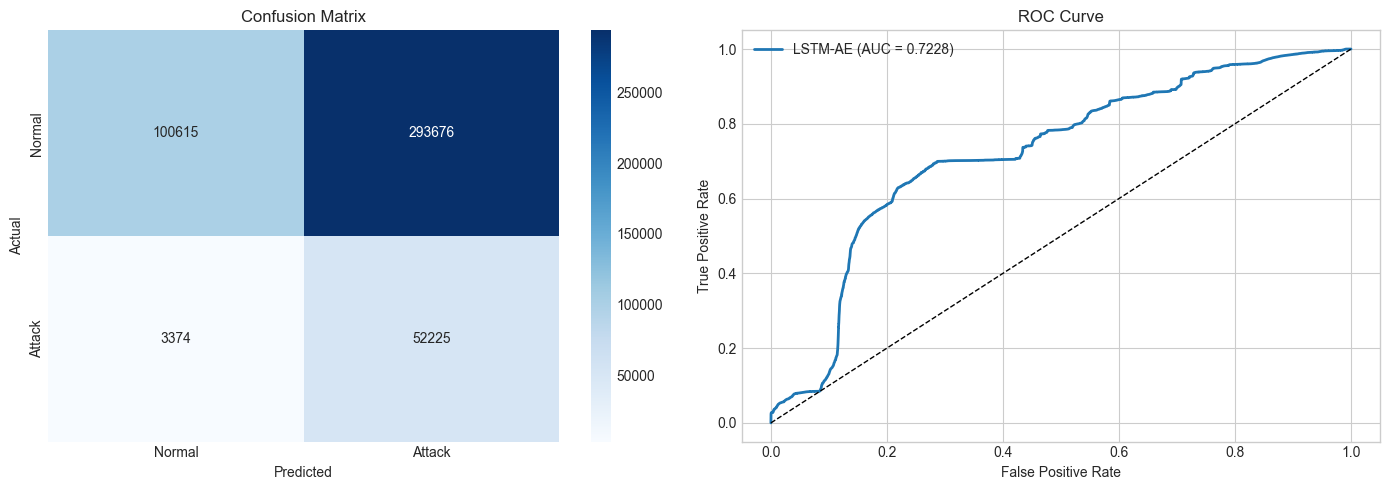

Saved: lstm_ae_evaluation.png


In [25]:
# Confusion matrix
cm = confusion_matrix(y_attack_seq, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'],
            ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# ROC curve
fpr, tpr, _ = roc_curve(y_attack_seq, test_errors)
axes[1].plot(fpr, tpr, linewidth=2, label=f'LSTM-AE (AUC = {auc_roc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('lstm_ae_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: lstm_ae_evaluation.png")

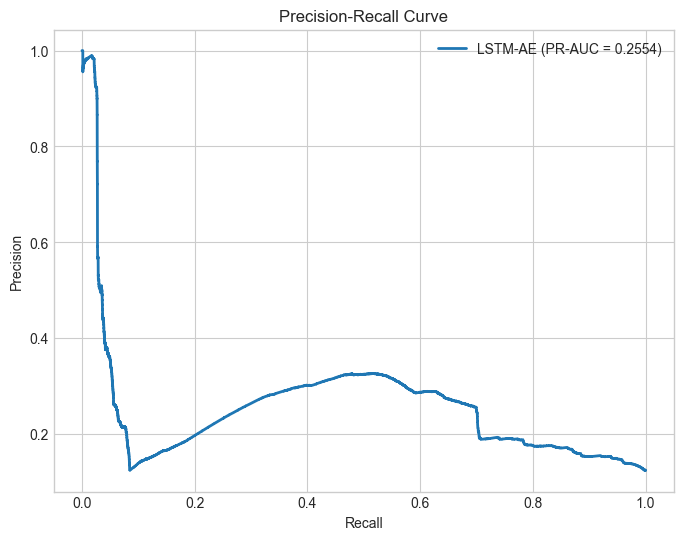

Saved: lstm_ae_pr_curve.png


In [26]:
# Precision-Recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_attack_seq, test_errors)
pr_auc = auc(recall_curve, precision_curve)

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, linewidth=2, label=f'LSTM-AE (PR-AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.savefig('lstm_ae_pr_curve.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: lstm_ae_pr_curve.png")

---
## Step 10: Visualize Reconstructions

In [27]:
def plot_reconstruction(original, reconstructed, sensor_idx=0, title=""):
    """
    Plot original vs reconstructed sequence for a specific sensor.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(original[:, sensor_idx], label='Original', linewidth=2)
    plt.plot(reconstructed[:, sensor_idx], label='Reconstructed', linewidth=2, linestyle='--')
    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.title(f'{title} - Sensor {sensor_cols[sensor_idx]}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

In [28]:
# Find examples of normal and attack sequences
normal_indices = np.where(y_attack_seq == 0)[0]
attack_indices = np.where(y_attack_seq == 1)[0]

# Get a normal sequence with low error
normal_errors = test_errors[normal_indices]
low_error_idx = normal_indices[np.argmin(normal_errors)]

# Get an attack sequence with high error
attack_errors = test_errors[attack_indices]
high_error_idx = attack_indices[np.argmax(attack_errors)]

print(f"Normal sequence (low error): index {low_error_idx}, error = {test_errors[low_error_idx]:.6f}")
print(f"Attack sequence (high error): index {high_error_idx}, error = {test_errors[high_error_idx]:.6f}")

Normal sequence (low error): index 33754, error = 0.000227
Attack sequence (high error): index 437612, error = 0.727384


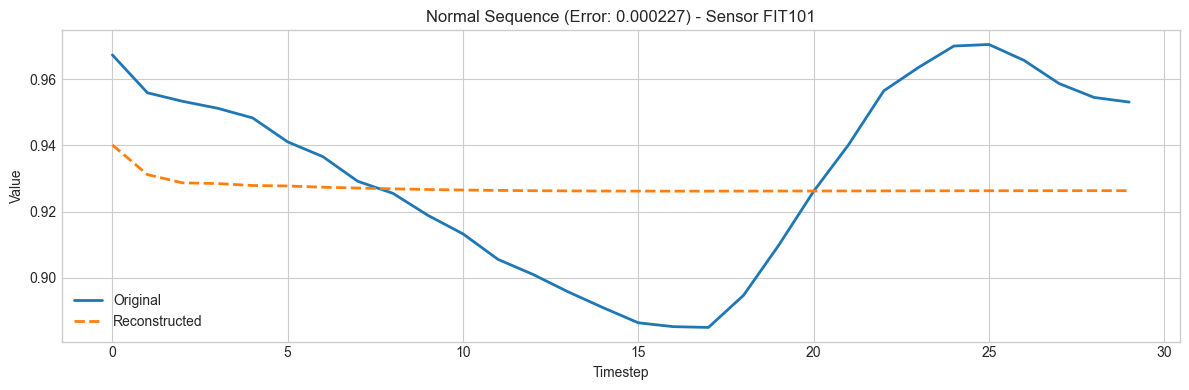

In [29]:
# Plot normal reconstruction
plot_reconstruction(
    X_attack_seq[low_error_idx],
    test_reconstructions[low_error_idx],
    sensor_idx=0,
    title=f'Normal Sequence (Error: {test_errors[low_error_idx]:.6f})'
)
plt.savefig('lstm_ae_normal_reconstruction.png', dpi=150, bbox_inches='tight')
plt.show()

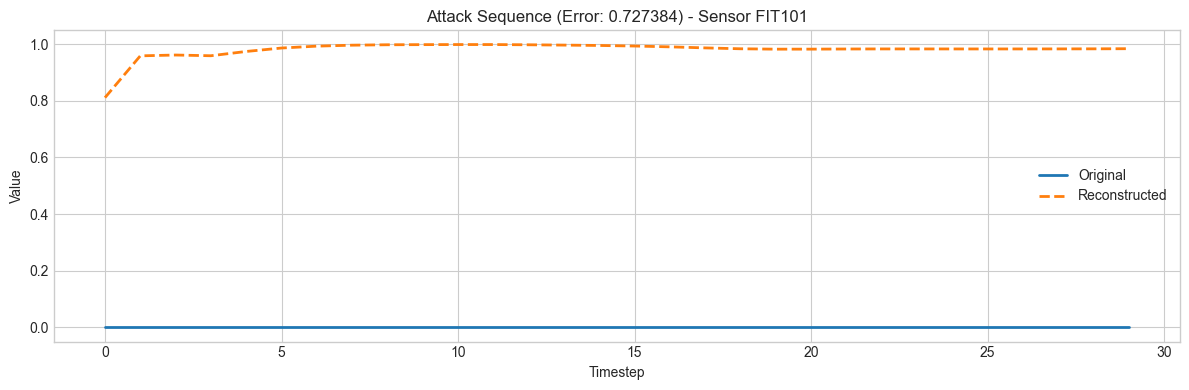

In [30]:
# Plot attack reconstruction
plot_reconstruction(
    X_attack_seq[high_error_idx],
    test_reconstructions[high_error_idx],
    sensor_idx=0,
    title=f'Attack Sequence (Error: {test_errors[high_error_idx]:.6f})'
)
plt.savefig('lstm_ae_attack_reconstruction.png', dpi=150, bbox_inches='tight')
plt.show()

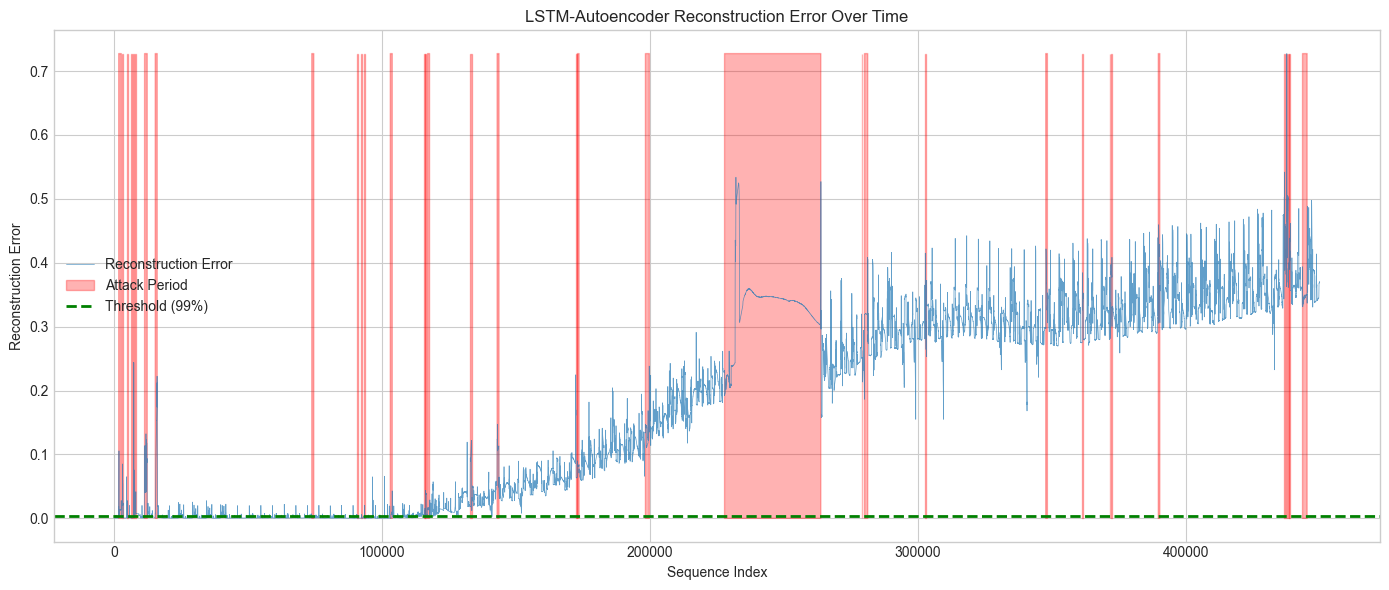

Saved: lstm_ae_errors_timeline.png


In [31]:
# Plot reconstruction errors over time
plt.figure(figsize=(14, 6))

# Plot errors
plt.plot(test_errors, alpha=0.7, linewidth=0.5, label='Reconstruction Error')

# Mark attack regions
attack_mask = y_attack_seq == 1
plt.fill_between(range(len(test_errors)), 0, test_errors.max(),
                 where=attack_mask, alpha=0.3, color='red', label='Attack Period')

# Threshold line
plt.axhline(y=BEST_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'Threshold ({BEST_PERCENTILE}%)')

plt.xlabel('Sequence Index')
plt.ylabel('Reconstruction Error')
plt.title('LSTM-Autoencoder Reconstruction Error Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('lstm_ae_errors_timeline.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: lstm_ae_errors_timeline.png")

---
## Step 11: Compare with Standard Autoencoder

In [32]:
def build_standard_autoencoder(n_features, latent_dim=32):
    """
    Build a standard (non-LSTM) autoencoder for comparison.
    """
    # Encoder
    inputs = Input(shape=(n_features,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    latent = Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = Dense(32, activation='relu')(latent)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(n_features, activation='sigmoid')(x)

    model = Model(inputs, outputs, name='Standard_Autoencoder')
    return model

# Build and train standard autoencoder
print("Building Standard Autoencoder for comparison...")
std_ae = build_standard_autoencoder(n_features, LATENT_DIM)
std_ae.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse')

# Train on flattened normal data (not sequences)
print("Training Standard Autoencoder...")
std_ae_history = std_ae.fit(
    X_normal_scaled, X_normal_scaled,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0
)
print("Standard Autoencoder trained!")

Building Standard Autoencoder for comparison...
Training Standard Autoencoder...
Standard Autoencoder trained!


In [33]:
# Evaluate standard autoencoder
std_ae_recon = std_ae.predict(X_attack_scaled, verbose=0)
std_ae_errors = np.mean(np.square(X_attack_scaled - std_ae_recon), axis=1)

# Get threshold from normal data
std_ae_train_recon = std_ae.predict(X_normal_scaled, verbose=0)
std_ae_train_errors = np.mean(np.square(X_normal_scaled - std_ae_train_recon), axis=1)
std_ae_threshold = np.percentile(std_ae_train_errors, BEST_PERCENTILE)

# Predictions
std_ae_preds = (std_ae_errors > std_ae_threshold).astype(int)

# Metrics
std_ae_acc = accuracy_score(y_attack, std_ae_preds)
std_ae_prec = precision_score(y_attack, std_ae_preds)
std_ae_rec = recall_score(y_attack, std_ae_preds)
std_ae_f1 = f1_score(y_attack, std_ae_preds)
std_ae_auc = roc_auc_score(y_attack, std_ae_errors)

print("Standard Autoencoder Performance:")
print(f"  Accuracy:  {std_ae_acc:.4f}")
print(f"  Precision: {std_ae_prec:.4f}")
print(f"  Recall:    {std_ae_rec:.4f}")
print(f"  F1-Score:  {std_ae_f1:.4f}")
print(f"  AUC-ROC:   {std_ae_auc:.4f}")

Standard Autoencoder Performance:
  Accuracy:  0.3512
  Precision: 0.1462
  Recall:    0.8979
  F1-Score:  0.2514
  AUC-ROC:   0.7972


In [34]:
# Comparison table
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': ['Standard Autoencoder', 'LSTM-Autoencoder'],
    'Accuracy': [std_ae_acc, accuracy],
    'Precision': [std_ae_prec, precision],
    'Recall': [std_ae_rec, recall],
    'F1-Score': [std_ae_f1, f1],
    'AUC-ROC': [std_ae_auc, auc_roc]
})

print(comparison_df.to_string(index=False))

# Calculate improvement
print("\n" + "-"*60)
print("LSTM-Autoencoder Improvement over Standard Autoencoder:")
print(f"  Accuracy:  {(accuracy - std_ae_acc)*100:+.2f}%")
print(f"  Precision: {(precision - std_ae_prec)*100:+.2f}%")
print(f"  Recall:    {(recall - std_ae_rec)*100:+.2f}%")
print(f"  F1-Score:  {(f1 - std_ae_f1)*100:+.2f}%")
print(f"  AUC-ROC:   {(auc_roc - std_ae_auc)*100:+.2f}%")


MODEL COMPARISON
               Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Standard Autoencoder  0.351219   0.146154 0.897900  0.251389 0.797201
    LSTM-Autoencoder  0.339727   0.150983 0.939315  0.260149 0.722791

------------------------------------------------------------
LSTM-Autoencoder Improvement over Standard Autoencoder:
  Accuracy:  -1.15%
  Precision: +0.48%
  Recall:    +4.14%
  F1-Score:  +0.88%
  AUC-ROC:   -7.44%


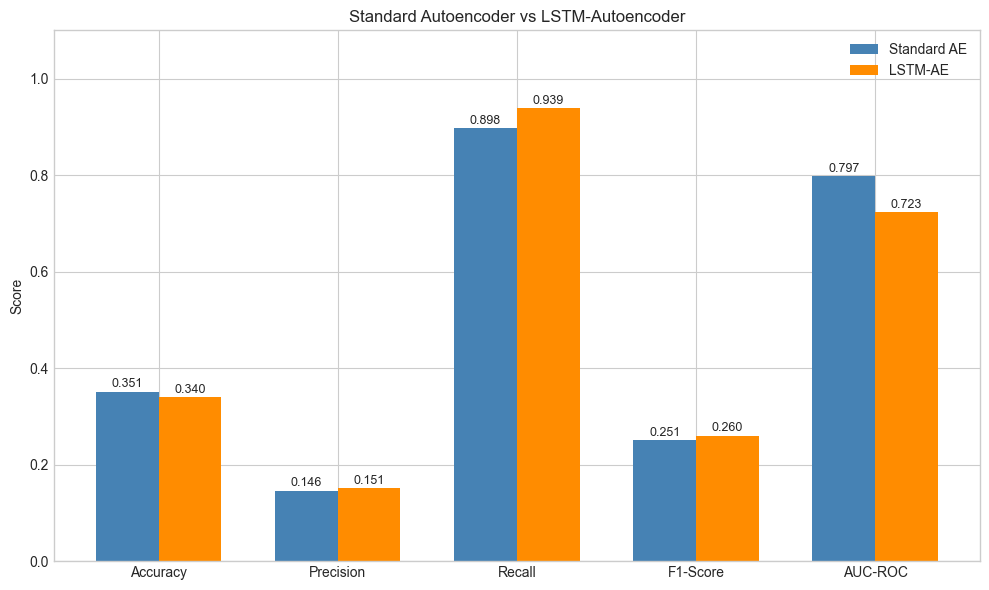

Saved: lstm_ae_comparison.png


In [35]:
# Visual comparison
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
std_values = [std_ae_acc, std_ae_prec, std_ae_rec, std_ae_f1, std_ae_auc]
lstm_values = [accuracy, precision, recall, f1, auc_roc]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, std_values, width, label='Standard AE', color='steelblue')
bars2 = ax.bar(x + width/2, lstm_values, width, label='LSTM-AE', color='darkorange')

ax.set_ylabel('Score')
ax.set_title('Standard Autoencoder vs LSTM-Autoencoder')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('lstm_ae_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: lstm_ae_comparison.png")

---
## Step 12: Save Model

In [36]:
import os

# Create directory
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Save model
model.save(f'{MODEL_SAVE_PATH}/lstm_autoencoder.keras')
print(f" Model saved: {MODEL_SAVE_PATH}/lstm_autoencoder.keras")

# Save scaler
joblib.dump(scaler, f'{MODEL_SAVE_PATH}/lstm_ae_scaler.pkl')
print(f" Scaler saved: {MODEL_SAVE_PATH}/lstm_ae_scaler.pkl")

# Save configuration
config = {
    'sequence_length': SEQUENCE_LENGTH,
    'n_features': n_features,
    'latent_dim': LATENT_DIM,
    'threshold': BEST_THRESHOLD,
    'threshold_percentile': BEST_PERCENTILE,
    'sensor_columns': sensor_cols
}
joblib.dump(config, f'{MODEL_SAVE_PATH}/lstm_ae_config.pkl')
print(f" Config saved: {MODEL_SAVE_PATH}/lstm_ae_config.pkl")

 Model saved: /Volumes/@tigasprilm@bx.d/u.du.d/0.d/Software Projects/VSCode/TKPSupport/models//lstm_autoencoder.keras
 Scaler saved: /Volumes/@tigasprilm@bx.d/u.du.d/0.d/Software Projects/VSCode/TKPSupport/models//lstm_ae_scaler.pkl
 Config saved: /Volumes/@tigasprilm@bx.d/u.du.d/0.d/Software Projects/VSCode/TKPSupport/models//lstm_ae_config.pkl


---
## Step 13: Inference Function

In [37]:
class LSTMAutoEncoderDetector:
    """
    LSTM-Autoencoder Anomaly Detector for SCADA systems.
    """

    def __init__(self, model_path, scaler_path, config_path):
        """Load trained model and configuration."""
        self.model = keras.models.load_model(model_path)
        self.scaler = joblib.load(scaler_path)
        self.config = joblib.load(config_path)

        self.seq_length = self.config['sequence_length']
        self.threshold = self.config['threshold']
        self.buffer = []  # Buffer to accumulate samples for sequence

        print(f"LSTM-AE Detector loaded")
        print(f"  Sequence length: {self.seq_length}")
        print(f"  Threshold: {self.threshold:.6f}")

    def add_sample(self, sample):
        """
        Add a new sample to the buffer.
        Returns anomaly prediction if buffer is full.
        """
        # Scale sample
        sample_scaled = self.scaler.transform(sample.reshape(1, -1))[0]
        self.buffer.append(sample_scaled)

        # Keep only last seq_length samples
        if len(self.buffer) > self.seq_length:
            self.buffer.pop(0)

        # If buffer full, make prediction
        if len(self.buffer) == self.seq_length:
            return self.predict()

        return None  # Not enough samples yet

    def predict(self):
        """
        Predict anomaly on current buffer.
        """
        sequence = np.array(self.buffer).reshape(1, self.seq_length, -1)
        reconstruction = self.model.predict(sequence, verbose=0)
        error = np.mean(np.square(sequence - reconstruction))

        is_anomaly = error > self.threshold

        return {
            'is_anomaly': is_anomaly,
            'error': error,
            'threshold': self.threshold
        }

    def predict_batch(self, data):
        """
        Predict on batch of sequences.
        """
        # Scale
        data_scaled = self.scaler.transform(data)

        # Create sequences
        sequences = create_sequences(data_scaled, seq_length=self.seq_length)

        # Predict
        reconstructions = self.model.predict(sequences, verbose=0)
        errors = np.mean(np.square(sequences - reconstructions), axis=(1, 2))

        predictions = (errors > self.threshold).astype(int)

        return predictions, errors

In [38]:
# Test the detector
print("Testing LSTM-AE Detector...")

detector = LSTMAutoEncoderDetector(
    model_path=f'{MODEL_SAVE_PATH}/lstm_autoencoder.keras',
    scaler_path=f'{MODEL_SAVE_PATH}/lstm_ae_scaler.pkl',
    config_path=f'{MODEL_SAVE_PATH}/lstm_ae_config.pkl'
)

# Test batch prediction
test_preds, test_errs = detector.predict_batch(X_attack[:1000])
print(f"\nBatch test on 1000 samples:")
print(f"  Anomalies detected: {test_preds.sum()}")
print(f"  Mean error: {test_errs.mean():.6f}")

Testing LSTM-AE Detector...
LSTM-AE Detector loaded
  Sequence length: 30
  Threshold: 0.004073

Batch test on 1000 samples:
  Anomalies detected: 2
  Mean error: 0.000611


---
## Summary

In [39]:
print("\n" + "="*70)
print("LSTM-AUTOENCODER ANOMALY DETECTION - SUMMARY")
print("="*70)

print(f"""
 MODEL ARCHITECTURE:
   Input: Sequences of {SEQUENCE_LENGTH} timesteps × {n_features} features

   Encoder:
   ├── LSTM ({LSTM_UNITS_1} units) → returns sequences
   ├── Dropout ({DROPOUT_RATE})
   ├── LSTM ({LSTM_UNITS_2} units) → returns last output
   └── Dense ({LATENT_DIM}) → latent space

   Decoder:
   ├── RepeatVector ({SEQUENCE_LENGTH})
   ├── LSTM ({LSTM_UNITS_2} units) → returns sequences
   ├── LSTM ({LSTM_UNITS_1} units) → returns sequences
   └── TimeDistributed(Dense({n_features})) → output

 PERFORMANCE:
   Accuracy:  {accuracy:.4f}
   Precision: {precision:.4f}
   Recall:    {recall:.4f}
   F1-Score:  {f1:.4f}
   AUC-ROC:   {auc_roc:.4f}

   Threshold: {BEST_THRESHOLD:.6f} ({BEST_PERCENTILE}th percentile)
   Training time: {training_time:.2f} seconds

 COMPARISON WITH STANDARD AUTOENCODER:
   LSTM-AE F1:     {f1:.4f}
   Standard AE F1: {std_ae_f1:.4f}
   Improvement:    {(f1 - std_ae_f1)*100:+.2f}%

 ADVANTAGES OF LSTM-AUTOENCODER:
   • Captures temporal dependencies in sequential SCADA data
   • Detects anomalies based on sequence patterns, not just point values
   • Better at detecting stealthy attacks that evolve over time
   • Learns normal temporal dynamics of the process

 CONSIDERATIONS:
   • Longer training time than standard autoencoders
   • Requires sequence of samples before prediction (latency)
   • More complex architecture requires more tuning
   • GPU recommended for efficient training
""")

print("="*70)


LSTM-AUTOENCODER ANOMALY DETECTION - SUMMARY

 MODEL ARCHITECTURE:
   Input: Sequences of 30 timesteps × 51 features

   Encoder:
   ├── LSTM (64 units) → returns sequences
   ├── Dropout (0.2)
   ├── LSTM (32 units) → returns last output
   └── Dense (32) → latent space

   Decoder:
   ├── RepeatVector (30)
   ├── LSTM (32 units) → returns sequences
   ├── LSTM (64 units) → returns sequences
   └── TimeDistributed(Dense(51)) → output

 PERFORMANCE:
   Accuracy:  0.3397
   Precision: 0.1510
   Recall:    0.9393
   F1-Score:  0.2601
   AUC-ROC:   0.7228

   Threshold: 0.004073 (99th percentile)
   Training time: 14425.36 seconds

 COMPARISON WITH STANDARD AUTOENCODER:
   LSTM-AE F1:     0.2601
   Standard AE F1: 0.2514
   Improvement:    +0.88%

 ADVANTAGES OF LSTM-AUTOENCODER:
   • Captures temporal dependencies in sequential SCADA data
   • Detects anomalies based on sequence patterns, not just point values
   • Better at detecting stealthy attacks that evolve over time
   • Learns n